# **Synthetic Cybersecurity Dataset Generator with Deep Learning Approaches - GANs**

This Jupyter notebook demonstrates the generation of synthetic cybersecurity datasets using Generative Adversarial Networks (GANs).

# Overview



*   Define generation parameters
*   Generate synthetic datasets
*   Save outputs for further analysis

# Key Features
# Requirements
* pandas for data manipulation
* scikit-learn for preprocessing
* sdv for synthetic data generation
* sdmetrics for evaluating synthetic data
* matplotlib for visualization

# Import Libraries
Load all necessary Python packages used throughout the notebook.

In [2]:
!pip install pandas sdv scikit-learn sdmetrics matplotlib --quiet

In [3]:
!pip cache purge
!pip install --no-cache-dir sdv --quiet

Files removed: 8


In [4]:
!pip install ctgan --quiet

In [5]:
!pip install tabfairgan --quiet

In [6]:
import numpy as np
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sdmetrics.reports.single_table import QualityReport, DiagnosticReport
from sdmetrics.single_table import KSComplement, DisclosureProtection

from ctgan import CTGAN
from tabfairgan import TFG

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ks_2samp
from sklearn.neighbors import NearestNeighbors

# Load the dataset (download from UCI)

Load the dataset, check for missing values, and inspect its structure.

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]
df = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

In [8]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [10]:
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0


# Encode Categorical Variables

The data contains 15 columns and 32561 instances.

To use it, it is neccessary to encode all to categorical columns into numeric format

In [11]:
categorical_cols = df.select_dtypes(include="object").columns
print(categorical_cols)

df_proc = df.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_proc[col] = le.fit_transform(df_proc[col])
    label_encoders[col] = le  # Save encoders to reverse later

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


In [12]:
# Preview processed data
df_proc.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


# CTGAN
Unlike traditional GANs, CTGAN uses a conditional generation approach that allows it to better learn and replicate the complex relationships in tabular datasets. It includes a mode-specific normalization strategy and employs training-by-sampling techniques to address imbalanced categorical columns, making it particularly effective for datasets with rare classes or discrete attributes.

In [63]:
ctgan = CTGAN(epochs=50)

In [64]:
#Make sure to use GPU
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [65]:
ctgan.fit(df_proc)

In [78]:
# Create synthetic data
synthetic_data = ctgan.sample(32561)
synthetic_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,18,4,254315,11,7,4,1,4,4,0,38,-1,21,39,0
1,65,6,350427,5,6,4,12,4,4,0,27,-1,40,20,0
2,60,7,55405,11,11,0,3,0,4,1,-34,0,40,39,1
3,49,6,98958,2,9,4,14,1,4,1,-15,1,40,39,0
4,58,4,105103,11,9,0,6,4,4,0,8,1,40,39,0


In [80]:
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

In [81]:
synthetic_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,18,4,254315,11,7,4,1,4,4,0,38,-1,21,39,0
1,65,6,350427,5,6,4,12,4,4,0,27,-1,40,20,0
2,60,7,55405,11,11,0,3,0,4,1,-34,0,40,39,1
3,49,6,98958,2,9,4,14,1,4,1,-15,1,40,39,0
4,58,4,105103,11,9,0,6,4,4,0,8,1,40,39,0


In [82]:
for col in categorical_cols:
    synthetic_df[col] = synthetic_df[col].round().astype(int)
    synthetic_df[col] = label_encoders[col].inverse_transform(synthetic_df[col].clip(
        0, len(label_encoders[col].classes_) - 1))

In [83]:
synthetic_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,18,Private,254315,HS-grad,7,Never-married,Adm-clerical,Unmarried,White,Female,38,-1,21,United-States,<=50K
1,65,Self-emp-not-inc,350427,7th-8th,6,Never-married,Sales,Unmarried,White,Female,27,-1,40,Iran,<=50K
2,60,State-gov,55405,HS-grad,11,Divorced,Craft-repair,Husband,White,Male,-34,0,40,United-States,>50K
3,49,Self-emp-not-inc,98958,12th,9,Never-married,Transport-moving,Not-in-family,White,Male,-15,1,40,United-States,<=50K
4,58,Private,105103,HS-grad,9,Divorced,Handlers-cleaners,Unmarried,White,Female,8,1,40,United-States,<=50K


In [22]:
# Save to CSV
synthetic_df.to_csv("synthetic_adult_income_ctgan.csv", index=False)

In [84]:
# If 'income' is the target variable
X_syn = synthetic_data.drop('income', axis=1)
y_syn = synthetic_data['income']

X_real = df_proc.drop('income', axis=1)
y_real = df_proc['income']


# Train a model on the real data
clf_real = RandomForestClassifier()
clf_real.fit(X_real, y_real)

# Evaluate on synthetic data
y_pred_syn = clf_real.predict(X_syn)

print("Evaluation of model trained on real data, tested on synthetic data:")
print(classification_report(y_syn, y_pred_syn))

# Train a model on synthetic data
clf_syn = RandomForestClassifier()
clf_syn.fit(X_syn, y_syn)

# Evaluate on real data
y_pred_real = clf_syn.predict(X_real)

print("\nEvaluation of model trained on synthetic data, tested on real data:")
print(classification_report(y_real, y_pred_real))

#Additional evaluation metrics (optional)

print(f"Accuracy on synthetic data: {accuracy_score(y_syn, y_pred_syn)}")
print(f"F1 score on synthetic data: {f1_score(y_syn, y_pred_syn)}")


Evaluation of model trained on real data, tested on synthetic data:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     23204
           1       0.79      0.55      0.65      9357

    accuracy                           0.83     32561
   macro avg       0.82      0.74      0.77     32561
weighted avg       0.82      0.83      0.82     32561


Evaluation of model trained on synthetic data, tested on real data:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     24720
           1       0.59      0.57      0.58      7841

    accuracy                           0.80     32561
   macro avg       0.73      0.72      0.72     32561
weighted avg       0.80      0.80      0.80     32561

Accuracy on synthetic data: 0.828813611375572
F1 score on synthetic data: 0.6466784989858012


The model trained on real data and tested on synthetic data achieved higher overall accuracy (83%) and F1-score (0.65 for class 1) compared to the reverse setup, suggesting better generalization from real to synthetic data. In contrast, training on synthetic data and testing on real data resulted in lower performance, particularly for class 1 (F1-score: 0.58), indicating limitations in synthetic data's ability to capture the full complexity of real-world patterns. These results highlight that while synthetic data can support model development, it may not be a full substitute for real data in training.

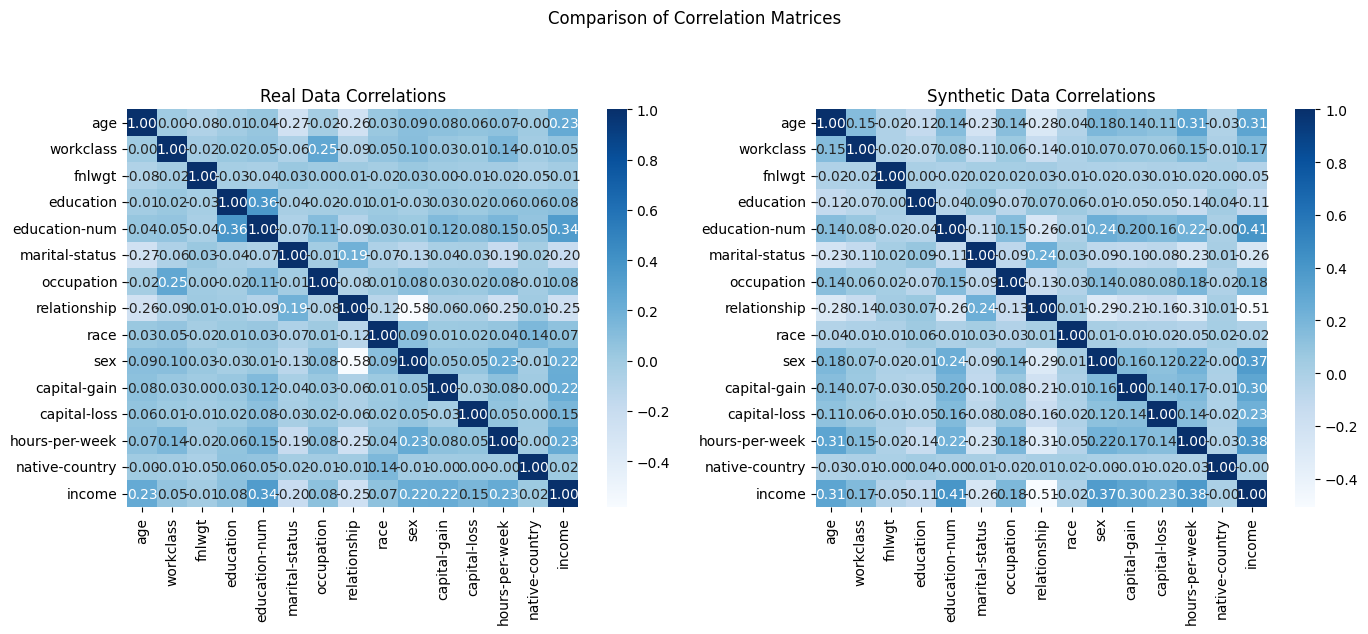

In [85]:
# Plot correlation matrices
plt.figure(figsize=(14, 6))
plt.suptitle('Comparison of Correlation Matrices', y=1.05)

plt.subplot(1, 2, 1)
sns.heatmap(df_proc.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Real Data Correlations")

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_data.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Synthetic Data Correlations")

plt.tight_layout()
plt.show()

The synthetic data can not copy the correlation exactly as it is in the real data. However, it follows closely, if there is a stronger connection between the columns it shows also in the synthetic data. For example income-age or income-sex.

In [87]:
from sdv.metadata import SingleTableMetadata

# Create and infer metadata from the real data
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_proc)

# Convert to dictionary (required by sdmetrics)
metadata_dict = metadata.to_dict()


====================== Synthetic data with CTGAN ======================

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 72.09it/s]|
Column Shapes Score: 89.55%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:00<00:00, 148.49it/s]|
Column Pair Trends Score: 80.15%

Overall Score (Average): 84.85%

Quality Score: 0.85


KS Scores:
age: 0.0602
workclass: 0.0723
fnlwgt: 0.0713
education: 0.0168
education-num: 0.0306
marital-status: 0.0134
occupation: 0.0793
relationship: 0.0721
race: 0.0191
sex: 0.0733
capital-gain: 0.5466
capital-loss: 0.2930
hours-per-week: 0.0705
native-country: 0.0415
income: 0.0466
DCR (Mean Distance): 138.7782
K-Anonymity - Real: 2, Synthetic: 2
L-Diversity - Real: 1, Synthetic: 1


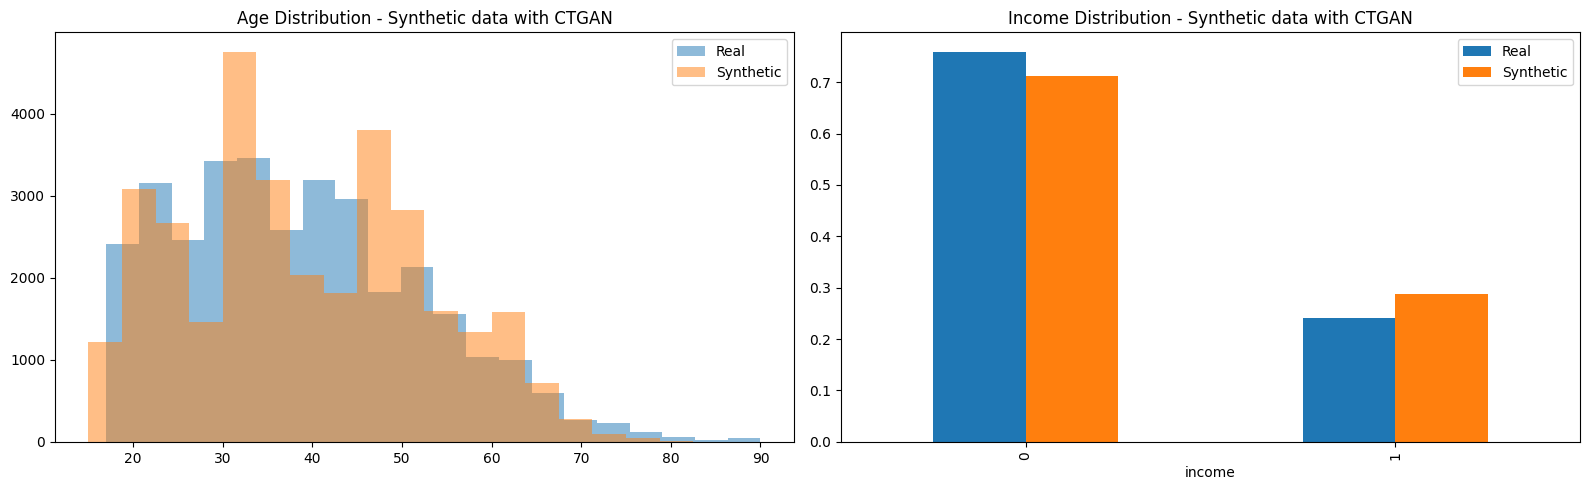

In [88]:
# Setup
synthetic_data = synthetic_data
dataset_name = "Synthetic data with CTGAN"
quasi_identifiers = ['age', 'education']
sensitive_column = 'income'

print(f"\n====================== {dataset_name} ======================\n")

### 1. Quality Report
quality = QualityReport()
quality.generate(real_data=df_proc, synthetic_data=synthetic_data, metadata=metadata_dict)
print(f"Quality Score: {quality.get_score():.2f}")
display(quality.get_visualization(property_name='Column Shapes'))

### 2. KS Score
print("KS Scores:")
numeric_cols = df_proc.select_dtypes(include='number').columns
for col in numeric_cols:
    ks_stat, _ = ks_2samp(df_proc[col], synthetic_data[col])
    print(f"{col}: {ks_stat:.4f}")

### 3. Distance to Closest Record (DCR)
def dcr(real, synth):
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(real)
    distances, _ = nn.kneighbors(synth)
    return np.mean(distances)

dcr_score = dcr(df_proc[numeric_cols], synthetic_data[numeric_cols])
print(f"DCR (Mean Distance): {dcr_score:.4f}")

### 4. K-Anonymity (Custom Approx)
def k_anonymity(df, qids):
    grouped = df[qids].groupby(qids).size()
    k_values = grouped[grouped > 1]
    return k_values.min() if not k_values.empty else 1

k_real = k_anonymity(df_proc, quasi_identifiers)
k_synth = k_anonymity(synthetic_data, quasi_identifiers)
print(f"K-Anonymity - Real: {k_real}, Synthetic: {k_synth}")

### 5. L-Diversity (Custom Approx)
def l_diversity(df, qids, sensitive):
    groups = df.groupby(qids)[sensitive].nunique()
    return groups.min() if not groups.empty else 0

l_real = l_diversity(df_proc, quasi_identifiers, sensitive_column)
l_synth = l_diversity(synthetic_data, quasi_identifiers, sensitive_column)
print(f"L-Diversity - Real: {l_real}, Synthetic: {l_synth}")

### 6. Visualize Distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Age
axes[0].hist(df_proc["age"], alpha=0.5, label="Real", bins=20)
axes[0].hist(synthetic_data["age"], alpha=0.5, label="Synthetic", bins=20)
axes[0].set_title(f"Age Distribution - {dataset_name}")
axes[0].legend()

# Income
income_real = df_proc["income"].value_counts(normalize=True)
income_synth = synthetic_data["income"].value_counts(normalize=True)
pd.DataFrame({"Real": income_real, "Synthetic": income_synth}).plot(kind="bar", ax=axes[1])
axes[1].set_title(f"Income Distribution - {dataset_name}")

plt.tight_layout()
plt.show()

### 7. Pairwise Relationships (Real vs Synthetic Labeling)
combined = df_proc.copy()
combined["__source__"] = "Real"
synth_copy = synthetic_data.copy()
synth_copy["__source__"] = "Synthetic"
combined = pd.concat([combined, synth_copy], ignore_index=True)


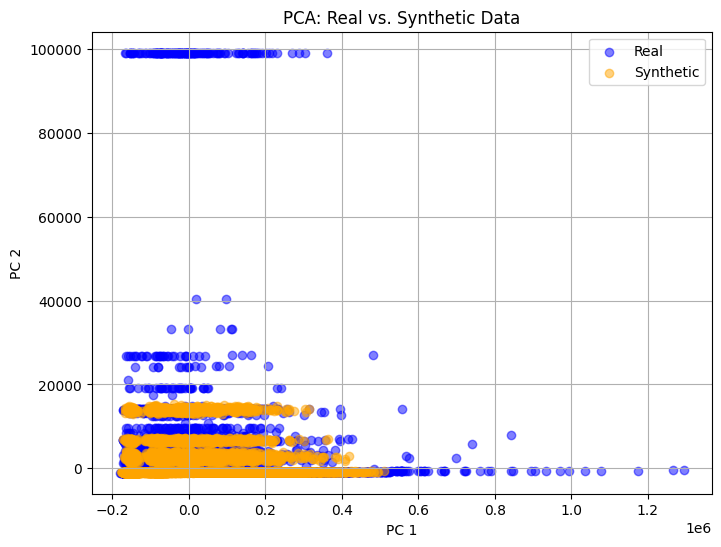

In [89]:
# Combine real and synthetic data
combined = pd.concat([df_proc, synthetic_data])

# Convert to array
labels = np.array(['Real'] * len(df_proc) + ['Synthetic'] * len(synthetic_data))

# PCA on numeric columns
pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined.select_dtypes(include=np.number))

# Plot with correct indexing
plt.figure(figsize=(8, 6))
plt.scatter(pca_results[labels == 'Real', 0], pca_results[labels == 'Real', 1], alpha=0.5, label='Real', c='blue')
plt.scatter(pca_results[labels == 'Synthetic', 0], pca_results[labels == 'Synthetic', 1], alpha=0.5, label='Synthetic', c='orange')
plt.legend()
plt.title("PCA: Real vs. Synthetic Data")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


# TabFairGAN

TabFairGAN extends the standard GAN framework by introducing fairness constraints during training. It is designed to generate synthetic tabular data that not only resembles the original distribution but also mitigates potential biases related to sensitive attributes like race, gender, or age. TabFairGAN is useful in contexts where preserving data utility and fairness is crucial, such as in HR, finance, or healthcare. It incorporates adversarial fairness objectives, ensuring that the generated data does not reinforce existing discrimination or bias patterns.

In [108]:
df_proc.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [109]:
# Define fairness configuration
fairness_config = {
    'fair_epochs': 40,
    'lamda': 0.5,
    'S': 'sex',
    'Y': 'income',
    'S_under': ' Female',
    'Y_desire': ' >50K'
}

# Initialize TabFairGAN with fairness constraints
tfg2 = TFG(df, epochs=50, batch_size=258, fairness_config=fairness_config)

# Train the model
tfg2.train()

Training Progress:   0%|                                                     | 0/50 [00:00<?, ?it/s]

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50


In [110]:
# Generate synthetic data
synthetic_data2 = tfg2.generate_fake_df(num_rows=32561)

In [111]:
synthetic_data2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49.0,Private,19302.000000,Assoc-acdm,13.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K
1,69.0,Federal-gov,181348.921875,Some-college,9.0,Widowed,Other-service,Husband,White,Female,0.0,0.0,40.0,France,<=50K
2,17.0,Private,210657.687500,Some-college,9.0,Never-married,Machine-op-inspct,Own-child,White,Male,0.0,0.0,15.0,United-States,<=50K
3,45.0,Self-emp-not-inc,109086.843750,HS-grad,9.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
4,44.0,?,19302.000000,Masters,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,>50K


In [112]:
# Save to CSV
synthetic_data2.to_csv("synthetic_adult_income_tabfairgan.csv", index=False)

In [35]:
!pip install sdmetrics

In [116]:
categorical_cols = synthetic_data2.select_dtypes(include="object").columns
print(categorical_cols)

synthetic_data2_proc = synthetic_data2.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    synthetic_data2_proc[col] = le.fit_transform(synthetic_data2_proc[col])
    label_encoders[col] = le  # Save encoders to reverse later

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


In [117]:
# If 'income' is the target variable
X_syn = synthetic_data2_proc.drop('income', axis=1)
y_syn = synthetic_data2_proc['income']

X_real = df_proc.drop('income', axis=1)
y_real = df_proc['income']


# Train a model on the real data
clf_real = RandomForestClassifier()
clf_real.fit(X_real, y_real)

# Evaluate on synthetic data
y_pred_syn = clf_real.predict(X_syn)

print("Evaluation of model trained on real data, tested on synthetic data:")
print(classification_report(y_syn, y_pred_syn))

# Train a model on synthetic data
clf_syn = RandomForestClassifier()
clf_syn.fit(X_syn, y_syn)

# Evaluate on real data
y_pred_real = clf_syn.predict(X_real)

print("\nEvaluation of model trained on synthetic data, tested on real data:")
print(classification_report(y_real, y_pred_real))

#Additional evaluation metrics (optional)

print(f"Accuracy on synthetic data: {accuracy_score(y_syn, y_pred_syn)}")
print(f"F1 score on synthetic data: {f1_score(y_syn, y_pred_syn)}")


Evaluation of model trained on real data, tested on synthetic data:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     24469
           1       0.69      0.47      0.56      8092

    accuracy                           0.82     32561
   macro avg       0.77      0.70      0.72     32561
weighted avg       0.81      0.82      0.80     32561


Evaluation of model trained on synthetic data, tested on real data:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     24720
           1       0.60      0.57      0.59      7841

    accuracy                           0.81     32561
   macro avg       0.73      0.73      0.73     32561
weighted avg       0.80      0.81      0.80     32561

Accuracy on synthetic data: 0.8171432081324284
F1 score on synthetic data: 0.5618837380426784


When trained on real data and tested on synthetic data, the model achieved higher accuracy (82%) and slightly better F1-score for class 1 (0.56) compared to training on synthetic data and testing on real data (accuracy: 81%, F1-score for class 1: 0.59). However, class 1 performance remains modest in both cases, indicating challenges in generalizing minority class patterns across data domains.


====================== Synthetic data with TABFAIRGAN ======================

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 24.20it/s]|
Column Shapes Score: 96.67%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:01<00:00, 63.53it/s]|
Column Pair Trends Score: 91.96%

Overall Score (Average): 94.31%

Quality Score: 0.94


K-Anonymity - Real: 2, Synthetic: 2
L-Diversity - Real: 1, Synthetic: 1


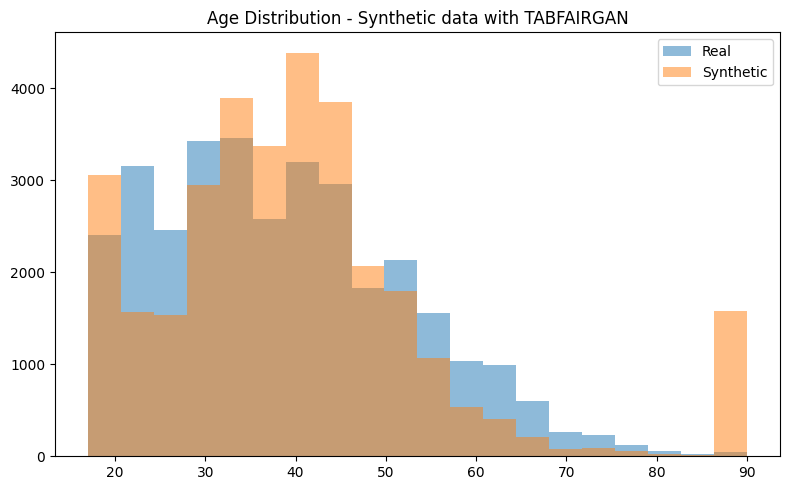

In [113]:
# Setup
synthetic_data = synthetic_data
dataset_name = "Synthetic data with TABFAIRGAN"
quasi_identifiers = ['age', 'education']
sensitive_column = 'income'

print(f"\n====================== {dataset_name} ======================\n")

### 1. Quality Report
quality = QualityReport()
quality.generate(real_data=df, synthetic_data=synthetic_data2, metadata=metadata_dict)
print(f"Quality Score: {quality.get_score():.2f}")
display(quality.get_visualization(property_name='Column Shapes'))




k_real = k_anonymity(df_proc, quasi_identifiers)
k_synth = k_anonymity(synthetic_data2, quasi_identifiers)
print(f"K-Anonymity - Real: {k_real}, Synthetic: {k_synth}")


l_real = l_diversity(df_proc, quasi_identifiers, sensitive_column)
l_synth = l_diversity(synthetic_data2, quasi_identifiers, sensitive_column)
print(f"L-Diversity - Real: {l_real}, Synthetic: {l_synth}")

### 6. Visualize Age Distributions
plt.figure(figsize=(8, 5))
plt.hist(df_proc["age"], alpha=0.5, label="Real", bins=20)
plt.hist(synthetic_data2["age"], alpha=0.5, label="Synthetic", bins=20)
plt.title(f"Age Distribution - {dataset_name}")
plt.legend()
plt.tight_layout()
plt.show()


### 7. Pairwise Relationships (Real vs Synthetic Labeling)
combined = df_proc.copy()
combined["__source__"] = "Real"
synth_copy = synthetic_data2.copy()
synth_copy["__source__"] = "Synthetic"
combined = pd.concat([combined, synth_copy], ignore_index=True)


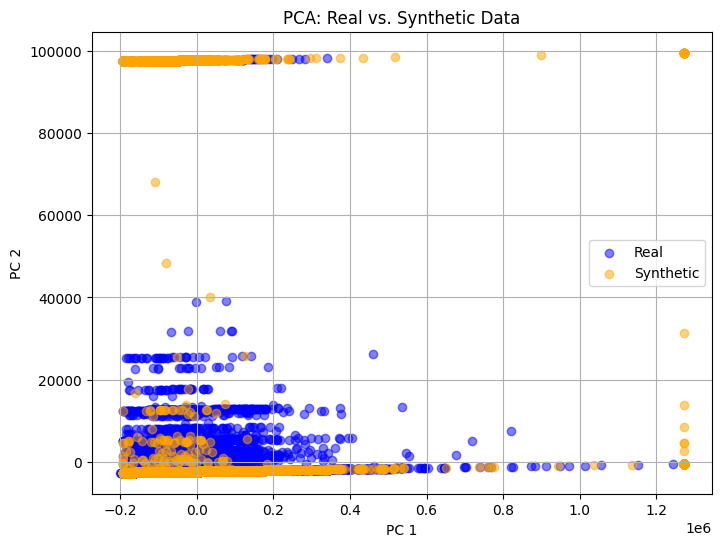

In [114]:
# Combine real and synthetic data
combined = pd.concat([df, synthetic_data2])

# Convert to array
labels = np.array(['Real'] * len(df) + ['Synthetic'] * len(synthetic_data))

# PCA on numeric columns
pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined.select_dtypes(include=np.number))

# Plot with correct indexing
plt.figure(figsize=(8, 6))
plt.scatter(pca_results[labels == 'Real', 0], pca_results[labels == 'Real', 1], alpha=0.5, label='Real', c='blue')
plt.scatter(pca_results[labels == 'Synthetic', 0], pca_results[labels == 'Synthetic', 1], alpha=0.5, label='Synthetic', c='orange')
plt.legend()
plt.title("PCA: Real vs. Synthetic Data")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


# Conclusion
This notebook demonstrates the potential of GAN-based synthetic data generation for cybersecurity applications. The generated data mimics the statistical distribution of real-world data, providing a privacy-preserving alternative for training and testing machine learning models. Such techniques can be a valuable asset in environments where data sharing is restricted.